Asian UV Index Data Analysis 

Importing Packages


In [1]:
import pdfplumber
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pptx import Presentation
from pptx.util import Inches
from scipy import stats

Global Styling

In [2]:
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

Parse PDF Dataset

In [3]:
pdf_path = "pyProjectData.pdf"

In [4]:
country_list = [
    "Japan","Thailand","Singapore","India","Indonesia","Philippines",
    "South Korea","China","Hong Kong","Malaysia","Vietnam","Bangladesh",
    "Taiwan","Sri Lanka","Mongolia","Cambodia","Myanmar",
    "Kazakhstan","Uzbekistan","Nepal","Pakistan","Laos"
]
country_set_1 = set([c for c in country_list if " " not in c])
country_set_2 = set([c for c in country_list if " " in c])

line_re = re.compile(
    r"^(?P<date>\d{4}-\d{2}-\d{2})(?P<mid>[A-Za-z\s]+?)\s+(?P<lat>-?\d+(?:\.\d+)?)\s+(?P<lon>-?\d+(?:\.\d+)?)\s+(?P<uv>\d+(?:\.\d+)?)"
    r"(?P<risk>Very High|High|Moderate|Low)\s+(?P<cloud>\d+)$"
)

records = []
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = (page.extract_text() or "").strip()
        for raw in text.splitlines():
            raw = raw.strip()
            m = line_re.match(raw)
            if not m:
                continue
            date_str = m.group("date")
            mid = m.group("mid").strip()
            lat = float(m.group("lat"))
            lon = float(m.group("lon"))
            uv = float(m.group("uv"))
            risk = m.group("risk")
            cloud = int(m.group("cloud"))
            # split into city/country
            tokens = mid.split()
            if len(tokens) >= 2:
                last_two = " ".join(tokens[-2:])
                if last_two in country_set_2:
                    country = last_two
                    city = " ".join(tokens[:-2])
                else:
                    country = tokens[-1]
                    city = " ".join(tokens[:-1])
            else:
                country = tokens[-1]
                city = " ".join(tokens[:-1])

            records.append({
                "Date": pd.to_datetime(date_str),
                "City": city,
                "Country": country,
                "Latitude": lat,
                "Longitude": lon,
                "UV_Index": uv,
                "Risk_Level": risk,
                "Cloud_Cover": cloud
            })

df = pd.DataFrame(records)
df.sort_values(["Date", "Country", "City"], inplace=True)
df.reset_index(drop=True, inplace=True)



Print the orginal data

In [ ]:
print(df.head())


Save Clean CSV

In [6]:
df.to_csv("asian_uv_index_2024_clean.csv", index=False)

Utility Function

In [7]:
def save_fig(fig, name):
    out = f"{name}.png"
    fig.savefig(out, bbox_inches="tight", dpi=200)
    plt.close(fig)
    return out

images = []

Plots

# 1) Distribution of UV Index

In [8]:
fig = plt.figure()
plt.hist(df["UV_Index"], bins=15, color='skyblue', edgecolor='black')
plt.title("Distribution of UV Index")
plt.xlabel("UV Index")
plt.ylabel("Frequency")
images.append(save_fig(fig, "uv_hist"))

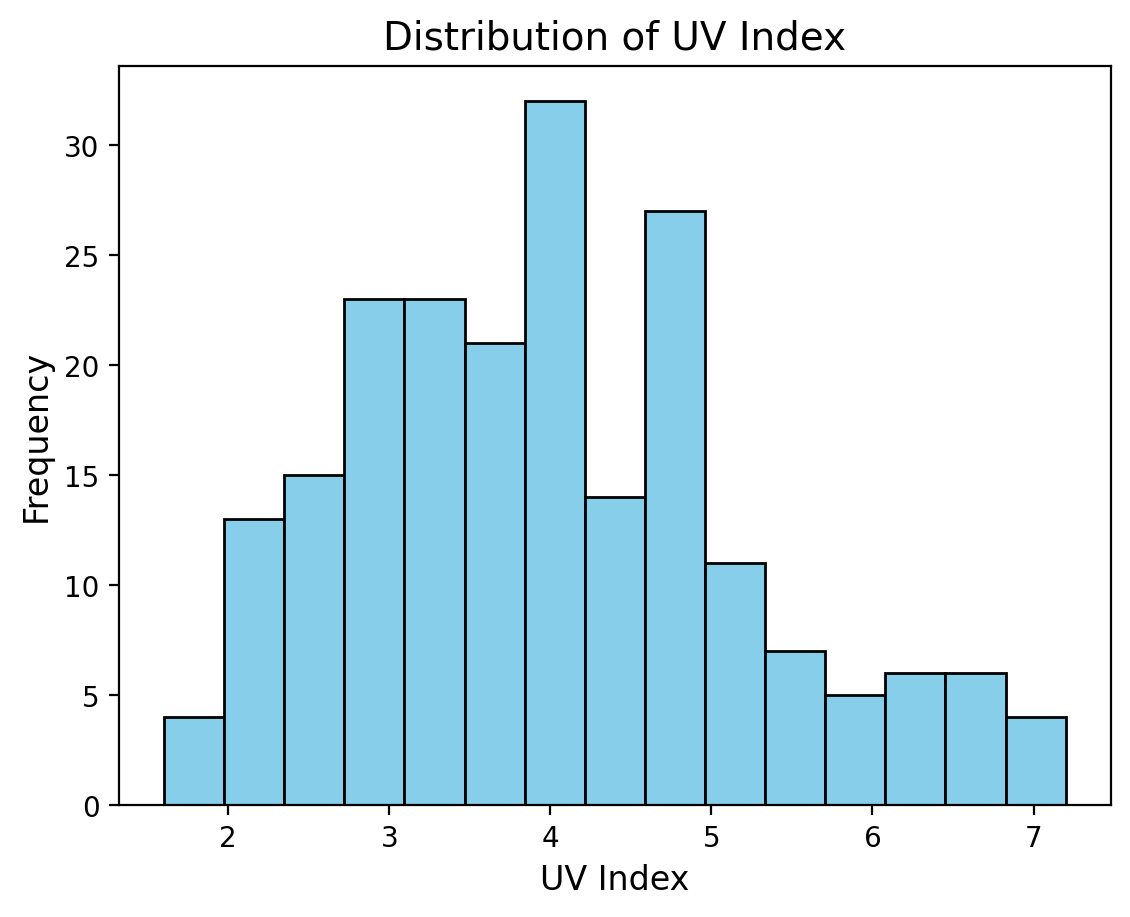

# 2) Top 10 Cities by Average UV

In [9]:
city_mean = df.groupby("City")["UV_Index"].mean().sort_values(ascending=False).head(10)
fig = plt.figure()
city_mean.plot(kind="bar", color='orange')
plt.title("Top 10 Cities by Average UV Index")
plt.ylabel("UV Index")
plt.xticks(rotation=45)
plt.tight_layout()
images.append(save_fig(fig, "city_avg_uv"))


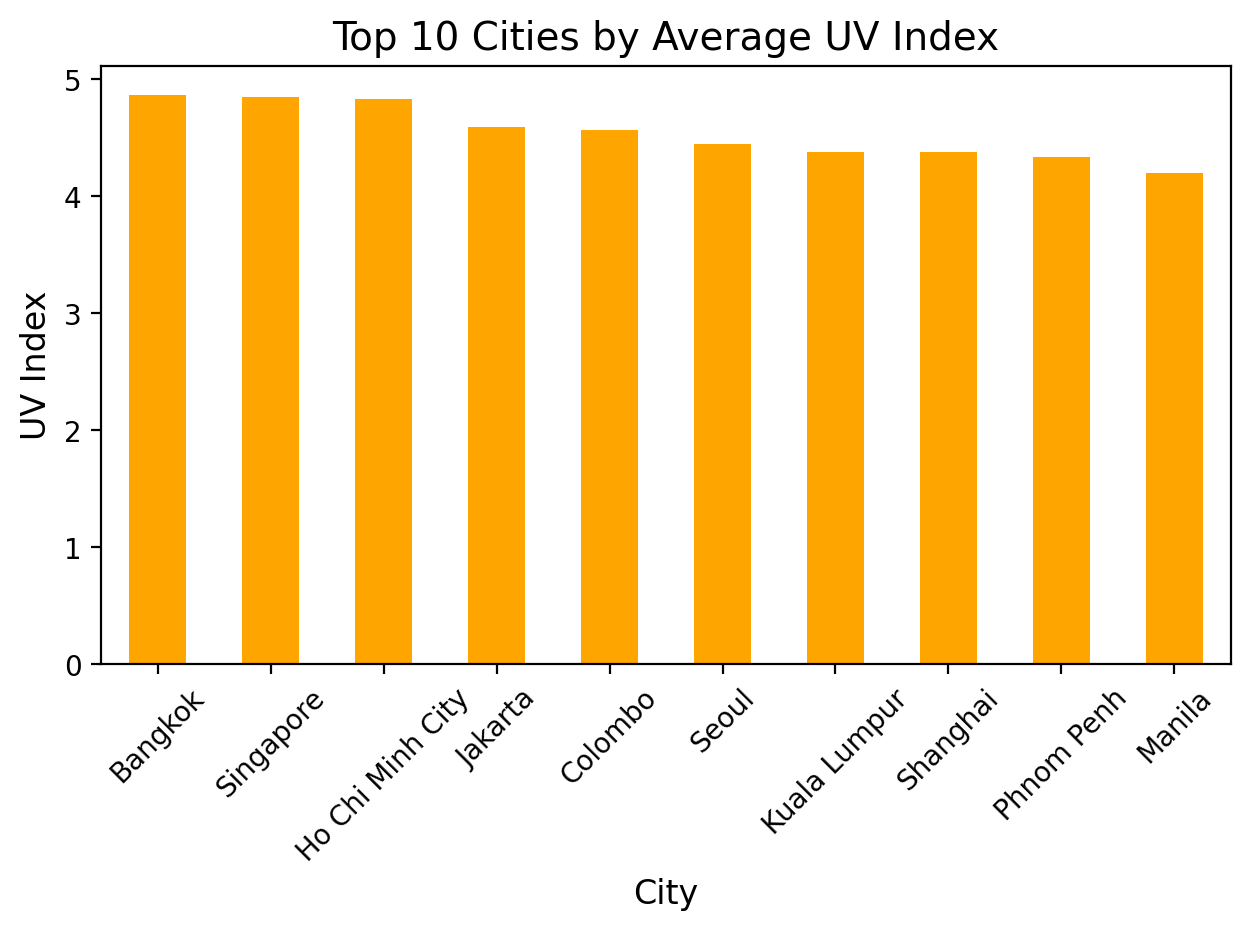

# 3) Dhaka UV over Time

In [ ]:
dhaka = df[df["City"] == "Dhaka"].sort_values("Date")
fig, ax = plt.subplots(figsize=(8.5, 6.2)) 

ax.plot(dhaka["Date"], dhaka["UV_Index"], marker='o', linestyle='-', color='steelblue')

ax.set_title("Dhaka UV Index Over Time", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("UV Index", fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

ax.grid(True, which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
images.append(save_fig(fig, "dhaka_trend"))


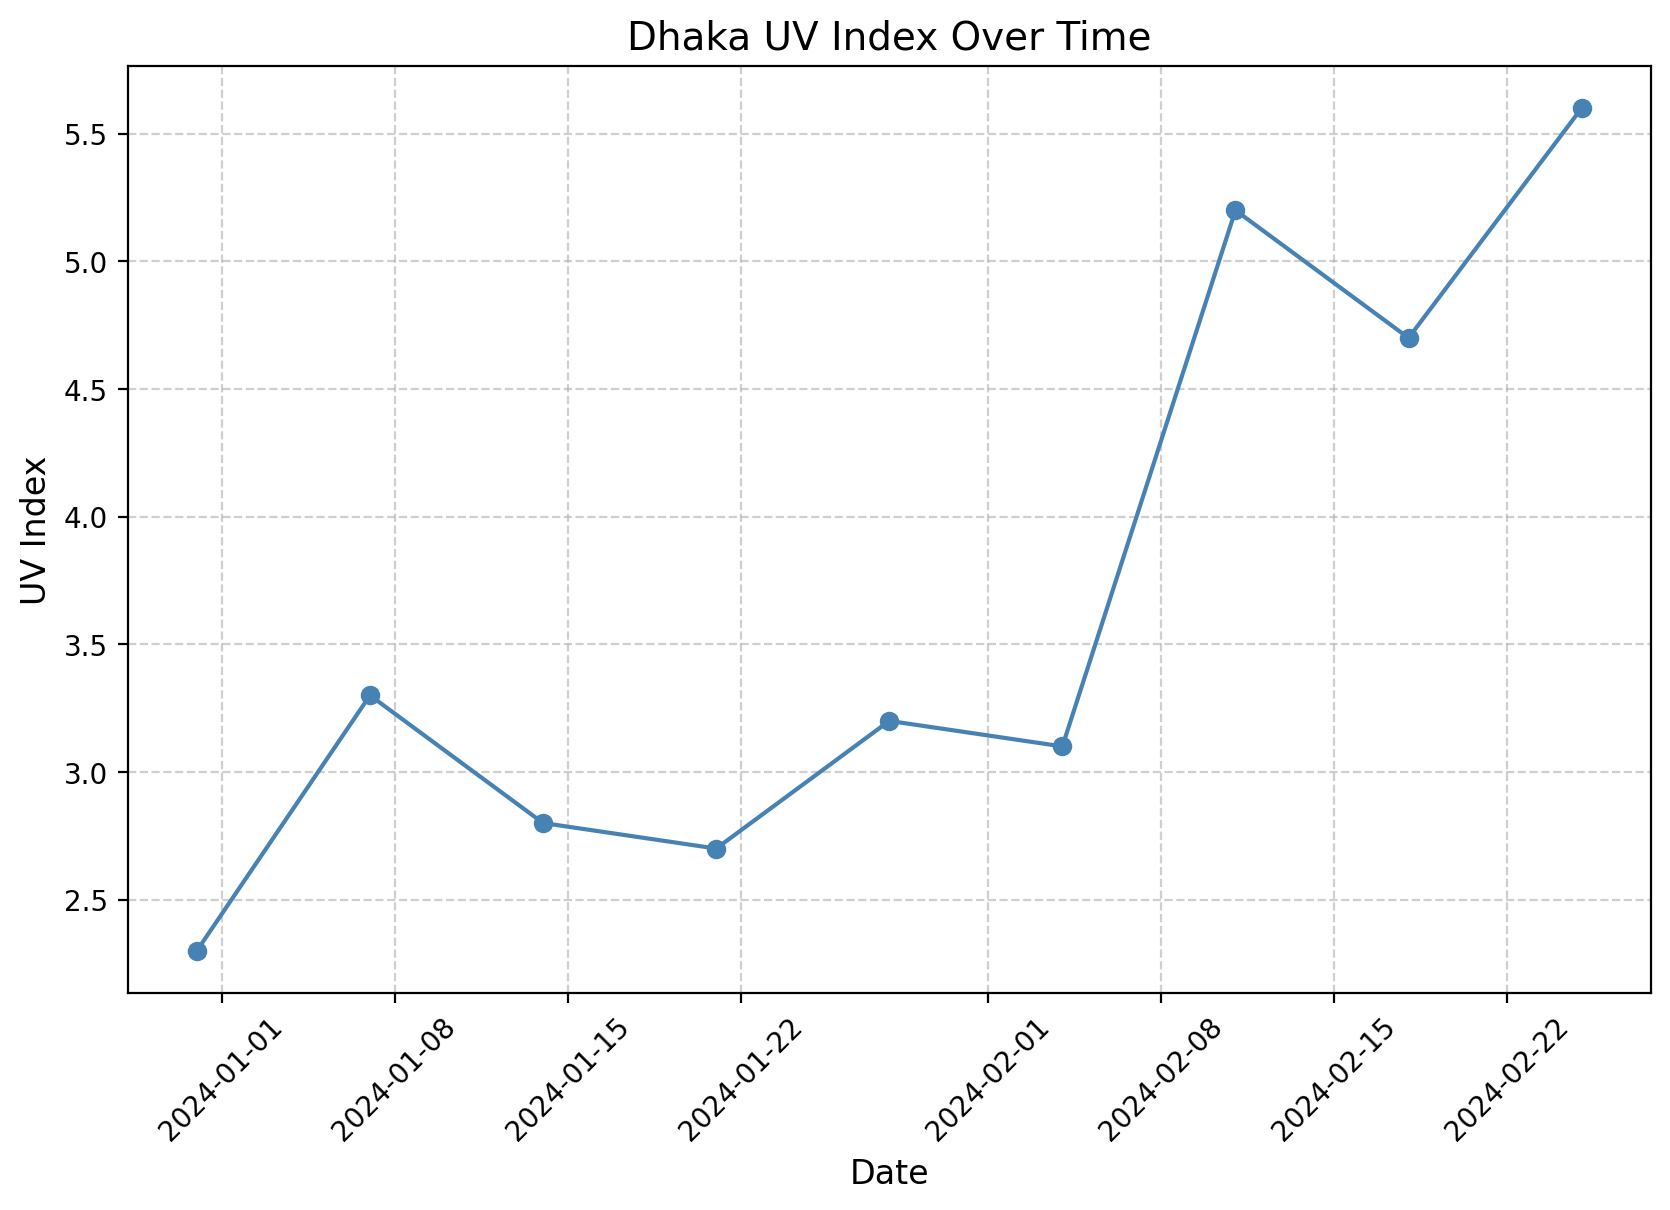

# 4) Cloud Cover vs UV Index

In [11]:
fig = plt.figure()
plt.scatter(df["Cloud_Cover"], df["UV_Index"], alpha=0.7, color='green')
plt.title("Cloud Cover vs UV Index")
plt.xlabel("Cloud Cover (%)")
plt.ylabel("UV Index")
plt.tight_layout()
images.append(save_fig(fig, "cloud_vs_uv"))

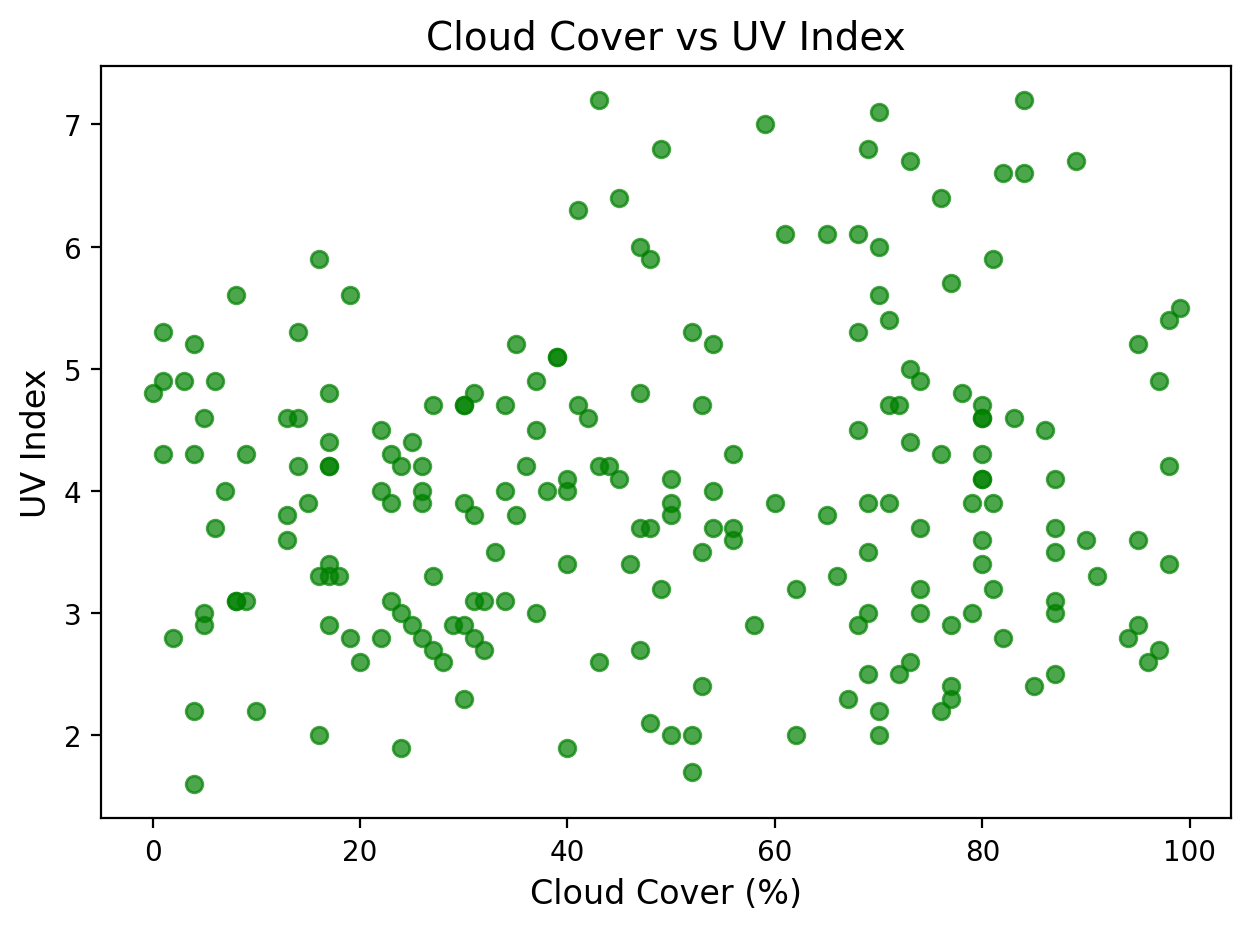

# 5) Risk Level Distribution

In [12]:
risk_counts = df["Risk_Level"].value_counts()
fig = plt.figure()
risk_counts.plot(kind="bar", color='red')
plt.title("Risk Level Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
images.append(save_fig(fig, "risk_dist"))

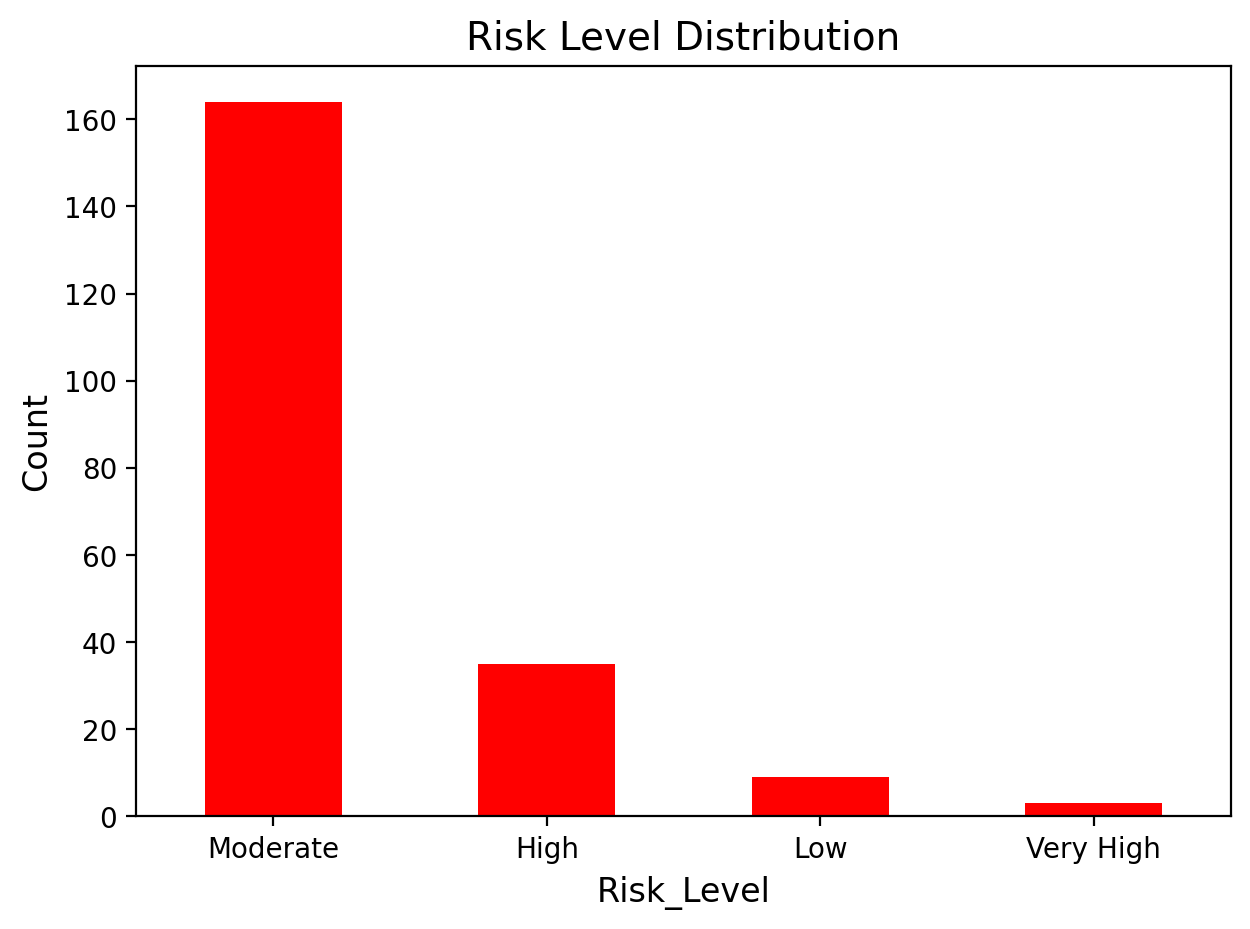

# 6) Average UV by Country

In [13]:
country_mean = df.groupby("Country")["UV_Index"].mean().sort_values(ascending=False).head(12)
fig = plt.figure()
country_mean.plot(kind="bar", color='purple')
plt.title("Average UV Index by Country")
plt.ylabel("UV Index")
plt.xticks(rotation=45)
plt.tight_layout()
images.append(save_fig(fig, "country_avg_uv"))

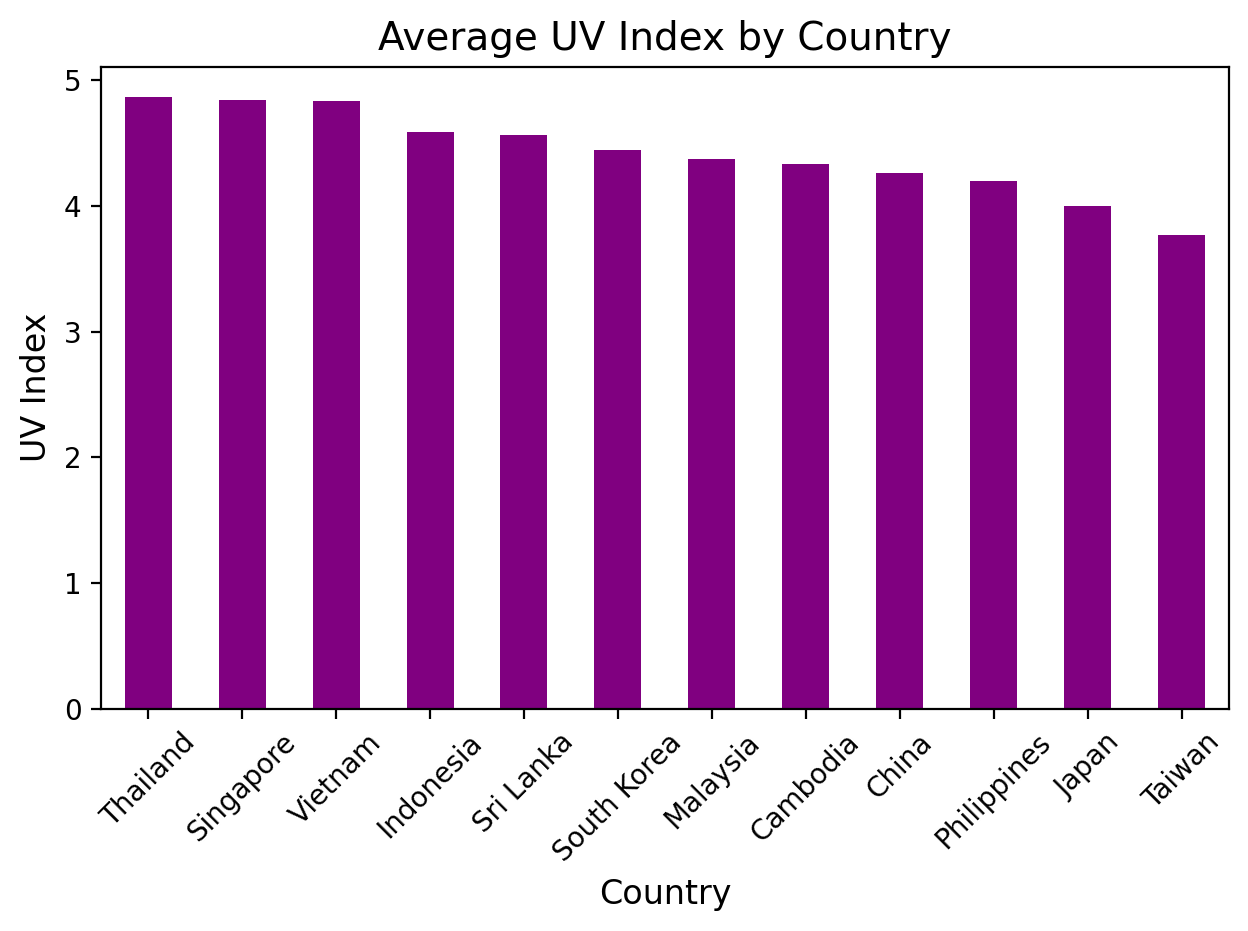

Hypothesis Test

In [14]:
x = df["Cloud_Cover"].values
y = df["UV_Index"].values
r_value, p_value = stats.pearsonr(x, y)
print(f"Pearson r = {r_value:.3f}, p = {p_value:.3e}")

Pearson r = 0.094, p = 1.726e-01


Build PowerPoint

In [15]:
prs = Presentation()
title_slide_layout = prs.slide_layouts[0]
blank_layout = prs.slide_layouts[6]

# Title Slide

In [16]:
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = "Asian UV Index 2024 — Statistical Data Analysis"
slide.placeholders[1].text = "Data Statistical Analysis Project"

# Add analysis plots

In [17]:
for i, img in enumerate(images, start=1):
    slide = prs.slides.add_slide(blank_layout)
    title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.6))
    title_box.text_frame.text = f"Analysis {i}"
    slide.shapes.add_picture(img, Inches(1), Inches(1.2), width=Inches(8))


# Save PPTX

In [18]:
prs.save("Asian_UV_Statistical_Analysis.pptx")
print("✅ Project completed. CSV, plots, and PPTX generated.")

✅ Project completed. CSV, plots, and PPTX generated.


Downloading Total Slides PPTX 